In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def fsk_modulator(bits, fc, fs, m, n):
    """
    FSK modulator
    :param bits: input bits
    :param fc: carrier frequency
    :param fs: sampling frequency
    :param m: number of bits per symbol
    :param n: number of carriers
    :return: modulated signal
    """
    # number of samples per symbol
    sps = fs // fc

    # number of symbols
    ns = len(bits) // m

    # number of samples
    nsamples = ns * sps

    # initialize output signal
    signal = np.zeros(nsamples)

    # generate carriers
    carriers = np.zeros((n, nsamples))
    for i in range(n):
        carriers[i, :] = np.cos(2 * np.pi * (fc + i) * np.arange(nsamples) / fs)

    # generate symbols
    symbols = np.zeros((ns, m))
    for i in range(ns):
        symbols[i, :] = bits[i * m:(i + 1) * m]

    # generate modulated signal
    for i in range(ns):
        signal[i * sps:(i + 1) * sps] = np.dot(symbols[i, :], carriers[:, i * sps:(i + 1) * sps])

    return signal

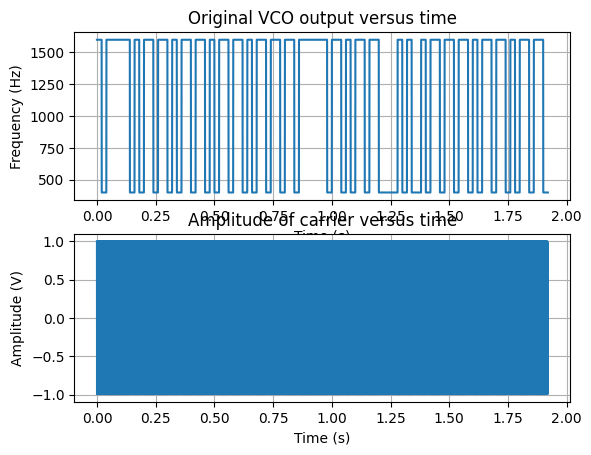

In [46]:
import numpy as np
import pylab as pl
import scipy.signal.signaltools as sigtool
import scipy.signal as signal
from numpy.random import sample

#the following variables setup the system
f_carrier = 1000       #simulate a carrier frequency of 1kHz
bitrate = 50       #simulated bitrate of data
f_dev = 600      #frequency deviation, make higher than bitrate

amp = 1           #transmitted signal amplitude
sample_f = 10000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
amp_n = 0.3      #noise peak amplitude
print_bits = 112 #number of bits to print in plots
text_to_send = "AIIII JOZIII" #text to send

def plot_data(y):
    pl.subplot(2,1,1)
    pl.plot(t[0:sample_f*print_bits//bitrate],m[0:sample_f*print_bits//bitrate])
    pl.xlabel('Time (s)')
    pl.ylabel('Frequency (Hz)')
    pl.title('Original VCO output versus time')
    pl.grid(True)

    pl.subplot(2,1,2)
    pl.plot(t[0:sample_f*print_bits//bitrate],y[0:sample_f*print_bits//bitrate])
    pl.xlabel('Time (s)')
    pl.ylabel('Amplitude (V)')
    pl.title('Amplitude of carrier versus time')
    pl.grid(True)
    pl.show()

"""
Data in
"""
#generate some random data for testing
#data_in = np.random.randint(0,2, size=bits_to_send)

#Convert text to ASCII and then to binary
data_in = ''.join(format(ord(i), '08b') for i in text_to_send)

#convert the data_in to a numpy array
data_in = np.array(list(data_in)).astype(int)

bits_to_send = len(data_in)     #how many bits to send
"""
VCO
"""
t = np.arange(0,float(bits_to_send)/float(bitrate),1/float(sample_f), dtype=float)
#extend the data_in to account for the bitrate and convert 0/1 to frequency
m = np.zeros(0).astype(float)
for bit in data_in:
    if bit == 0:
        m=np.hstack((m,np.multiply(np.ones(sample_f//bitrate),f_carrier+f_dev)))
    else:
        m=np.hstack((m,np.multiply(np.ones(sample_f//bitrate),f_carrier-f_dev)))
#calculate the output of the VCO
y = np.zeros(0)
y = amp * np.cos(2*np.pi*np.multiply(m,t))
#pl.plot(m)
#pl.plot(data_in)
plot_data(y)


SNR = 8.000830dB


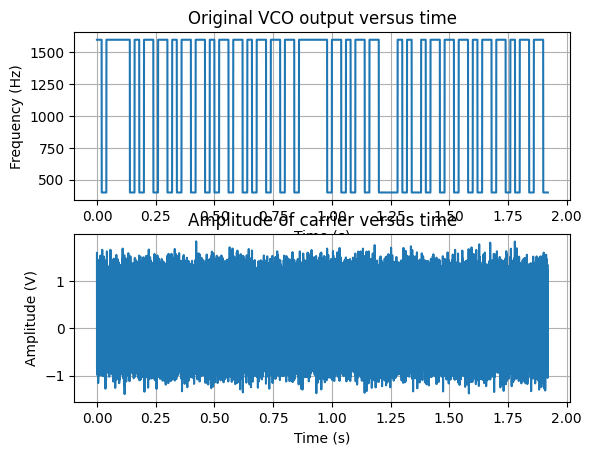

/tmp/ipykernel_726534/2969033890.py:21: DeprecationWarning: Please use `hilbert` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  y_env = np.abs(sigtool.hilbert(y_diff))


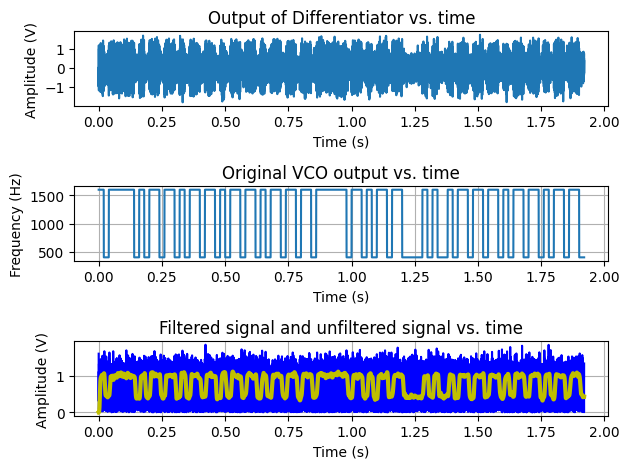

Received data = AIIII JOZIII
bit errors = 0
bit error percent = 0.00%


In [47]:

"""
bits_to_sendoisy Channel
"""
#create some noise
noise = (np.random.randn(len(y))+1)*amp_n
snr = 10*np.log10(np.mean(np.square(y)) / np.mean(np.square(noise)))
print("SNR = %fdB" % snr) 
y=np.add(y,noise)
#view the data after adding noise
plot_data(y)

"""
Differentiator
"""
y_diff = np.diff(y,prepend=y[0])

"""
Envelope detector + low-pass filter
"""
#create an envelope detector and then low-pass filter
y_env = np.abs(sigtool.hilbert(y_diff))
h=signal.firwin( numtaps=100, cutoff=bitrate*2, nyq=sample_f/2)
y_filtered=signal.lfilter( h, 1.0, y_env)

# view the output of the differentiator
pl.subplot(3,1,1)
pl.plot(t[0:sample_f*print_bits//bitrate],y_diff[0:sample_f*print_bits//bitrate])
pl.xlabel('Time (s)')
pl.ylabel('Amplitude (V)')
pl.title('Output of Differentiator vs. time')

#view the data after adding noise
pl.subplot(3,1,2)
pl.plot(t[0:sample_f*print_bits//bitrate],m[0:sample_f*print_bits//bitrate])
pl.xlabel('Time (s)')
pl.ylabel('Frequency (Hz)')
pl.title('Original VCO output vs. time')
pl.grid(True)

pl.subplot(3,1,3)
pl.plot(t[0:sample_f*print_bits//bitrate],np.abs(y[0:sample_f*print_bits//bitrate]),'b')
pl.plot(t[0:sample_f*print_bits//bitrate],y_filtered[0:sample_f*print_bits//bitrate],'y',linewidth=3.0)
pl.xlabel('Time (s)')
pl.ylabel('Amplitude (V)')
pl.title('Filtered signal and unfiltered signal vs. time')
pl.grid(True)
pl.tight_layout()
pl.show()

"""
slicer
"""
#calculate the mean of the signal
mean = np.mean(y_filtered)
#if the mean of the bit period is higher than the mean, the data is a 0
rx_data = []
sampled_signal = y_filtered[sample_f//bitrate//2:len(y_filtered):sample_f//bitrate]
for bit in sampled_signal:
    if bit > mean:
        rx_data.append(0)
    else:
        rx_data.append(1)

bit_error=0
for i in range(0,len(data_in)):
    if rx_data[i] != data_in[i]:
        bit_error+=1

aijozi = ''.join(chr(int(''.join(map(str, rx_data[i:i+8])), 2)) for i in range(0, len(rx_data), 8))



print ("Received data = %s" % aijozi)
print ("bit errors = %d" % bit_error)
print ("bit error percent = %4.2f%%" % (float(bit_error)/float(bits_to_send)*100))